<a href="https://colab.research.google.com/github/TarfaGaida/Time-Forecast/blob/main/HW_ECDay7_TimeForecasting_Tarfa_Gaida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sktime[all_extras]

In [2]:
# utilities packages
import datetime

# data wrangling and transformation package
import numpy as np
import pandas as pd
import statsmodels.api as sm

# data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# time series modeling
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.stats.diagnostic import acorr_ljungbox

# load sktime for time series forecasting
from sktime.utils.plotting import plot_series # from plotting
from sktime.forecasting.naive import NaiveForecaster # for naive forecasting
from sktime.forecasting.arima import AutoARIMA # for automated ARIMA forecasting
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # for exponential smoothing forecasting
from sktime.forecasting.ets import AutoETS # for automated ETS forecasting
from sktime.forecasting.tbats import TBATS # for TBATS forecasting
from sktime.forecasting.fbprophet import Prophet # for Prophet forecasting
from sktime.forecasting.base import ForecastingHorizon # for creating forecast horizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    SlidingWindowSplitter
) # for train-test split and cross validation
from sktime.performance_metrics.forecasting import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
) # for evaluation metrics
from sktime.forecasting.model_evaluation import evaluate # for evaluating CV results

%matplotlib inline

In [3]:
urls = [
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_january_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_february_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_march_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_april_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_may_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_june_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_july_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_august_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_september_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_october_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_november_2019.csv",
    "https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/ecommerce_time_series_analysis/sales_data_december_2019.csv",
]

# Create an empty list to store DataFrames
dfs = []

# Loop through the URLs, read each CSV, and append to the list
for url in urls:
    df = pd.read_csv(url) # Read each CSV file individually
    dfs.append(df)       # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
sales_data_2019 = pd.concat(dfs, ignore_index=True)

In [4]:
sales_data_2019.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"


In [5]:
sales_data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


In [6]:
sales_data_2019.isna().sum()

,0
Order ID,545
Product,545
Quantity Ordered,545
Price Each,545
Order Date,545
Purchase Address,545


In [7]:
#check, if missing value in the same row in every column
sales_data_2019[sales_data_2019.isna().all(axis=1)]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
664,NaN,NaN,NaN,NaN,NaN,NaN
678,NaN,NaN,NaN,NaN,NaN,NaN
797,NaN,NaN,NaN,NaN,NaN,NaN
876,NaN,NaN,NaN,NaN,NaN,NaN
1299,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
184678,NaN,NaN,NaN,NaN,NaN,NaN
184695,NaN,NaN,NaN,NaN,NaN,NaN
185042,NaN,NaN,NaN,NaN,NaN,NaN
185729,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#all missing value in teh same row, drop all
sales_data_2019.dropna(how='all', inplace=True)

In [9]:
sales_data_2019.isna().sum()

,0
Order ID,0
Product,0
Quantity Ordered,0
Price Each,0
Order Date,0
Purchase Address,0


In [10]:
#check dupliate
sales_data_2019.duplicated().sum()

618

In [11]:
#drop duplicate data
sales_data_2019.drop_duplicates(inplace=True)

In [12]:
#check dupliate
sales_data_2019.duplicated().sum()

0

In [13]:
# Mengonversi kolom yang seharusnya numerik
sales_data_2019['Quantity Ordered'] = pd.to_numeric(sales_data_2019['Quantity Ordered'], errors='coerce')
sales_data_2019['Price Each'] = pd.to_numeric(sales_data_2019['Price Each'], errors='coerce')

In [14]:
# Mengonversi Order Date menjadi datetime
sales_data_2019['Order Date'] = pd.to_datetime(sales_data_2019['Order Date'], errors='coerce')

<ipython-input-14-866ef84f1364>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales_data_2019['Order Date'] = pd.to_datetime(sales_data_2019['Order Date'], errors='coerce')


In [15]:
sales_data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185687 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185687 non-null  object        
 1   Product           185687 non-null  object        
 2   Quantity Ordered  185686 non-null  float64       
 3   Price Each        185686 non-null  float64       
 4   Order Date        185686 non-null  datetime64[ns]
 5   Purchase Address  185687 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 9.9+ MB


In [16]:
# Menambahkan kolom Total sales (Total Revenue per order line),menunjang soal no1
sales_data_2019['Total sales'] = sales_data_2019['Quantity Ordered'] * sales_data_2019['Price Each']

In [17]:
sales_data_2019.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total sales
0,141234,iPhone,1.0,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",700.00
1,141235,Lightning Charging Cable,1.0,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",14.95
2,141236,Wired Headphones,2.0,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",23.98
3,141237,27in FHD Monitor,1.0,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",149.99
4,141238,Wired Headphones,1.0,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",11.99


In [18]:
# ekstrak informasi waktu, untuk no.2
sales_data_2019['Year'] = sales_data_2019['Order Date'].dt.year
sales_data_2019['Month'] = sales_data_2019['Order Date'].dt.month
sales_data_2019['Week'] = sales_data_2019['Order Date'].dt.isocalendar().week
sales_data_2019['Day'] = sales_data_2019['Order Date'].dt.day
sales_data_2019['Hour'] = sales_data_2019['Order Date'].dt.hour

In [19]:
# ekstrak mengambil nama kota dari Purchase Address, untuk no 3
sales_data_2019['City'] = sales_data_2019['Purchase Address'].apply(lambda x: x.split(', ')[1] if ', ' in x and len(x.split(', ')) > 1 else None)


In [20]:
sales_data_2019.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total sales,Year,Month,Week,Day,Hour,City
0,141234,iPhone,1.0,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",700.00,2019.0,1.0,4,22.0,21.0,Boston
1,141235,Lightning Charging Cable,1.0,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",14.95,2019.0,1.0,5,28.0,14.0,Portland
2,141236,Wired Headphones,2.0,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",23.98,2019.0,1.0,3,17.0,13.0,San Francisco
3,141237,27in FHD Monitor,1.0,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",149.99,2019.0,1.0,1,5.0,20.0,Los Angeles
4,141238,Wired Headphones,1.0,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",11.99,2019.0,1.0,4,25.0,11.0,Austin


NO.1
* total revenue, jumlah order, dan jumlah barang yang terjual
tahun 2019.
*  rata-rata jumlah barang yang dibeli per transaksi dan
rata-rata spending per transaksi

In [21]:
total_revenue = sales_data_2019['Total sales'].sum()
total_orders = sales_data_2019['Order ID'].nunique()
total_products = sales_data_2019['Quantity Ordered'].sum()

average_products_per_order = sales_data_2019.groupby('Order ID')['Quantity Ordered'].sum().mean()
average_spending_per_order = sales_data_2019.groupby('Order ID')['Total sales'].sum().mean()

In [22]:
print("Total Revenue:", total_revenue)
print("Total Orders:", total_orders)
print("Total Products:", total_products)
print("Average Products per Order:", average_products_per_order)
print("Average Spending per Order:", average_spending_per_order)

Total Revenue: 34465537.94
Total Orders: 178438
Total Products: 208812.0
Average Products per Order: 1.170221589571728
Average Spending per Order: 193.15133514161775


* Total Revenue: $34,465,537.94

* Jumlah Order: 178,437 transaksi
* Jumlah Barang Terjual: 208,812 unit
* Rata-rata Jumlah Barang per Transaksi: 1.17 unit
* Rata-rata Spending per Transaksi: $193.15

No. 2
Hitunglah jumlah order dan GMV yang diperoleh dengan rentang waktu berikut:
a. Harian
b. Mingguan
c. Bulanan

In [23]:
# 2. Menghitung jumlah order dan GMV (Gross Merchandise Value) berdasarkan rentang waktu

# Harian
daily_orders = sales_data_2019.groupby(['Year', 'Month','Day']).agg({'Order ID': 'nunique', 'Total sales': 'sum'})

# Mingguan
weekly_orders = sales_data_2019.groupby(['Year', 'Week']).agg({'Order ID': 'nunique', 'Total sales': 'sum'})

# Bulanan
monthly_orders = sales_data_2019.groupby(['Year', 'Month']).agg({'Order ID': 'nunique', 'Total sales': 'sum'})


In [24]:
daily_orders.head()

Order ID  Total sales
Year   Month Day                       
2019.0 1.0   1.0       287     65681.94
             2.0       308     70663.20
             3.0       286     47046.20
             4.0       282     62000.22
             5.0       301     46524.63

In [25]:
weekly_orders.head()


Order ID  Total sales
Year   Week                       
2019.0 1         3259    627975.87
       2         2104    409389.43
       3         2104    394921.11
       4         2134    426020.17
       5         2381    459570.62

In [26]:
monthly_orders.head()

Order ID  Total sales
Year   Month                       
2019.0 1.0        9262   1812742.87
       2.0       11496   2200078.08
       3.0       14549   2804973.35
       4.0       17528   3389217.98
       5.0       15836   3150616.23

total revenue  dan jumlah order berdasarkan rentang waktu, (example)

Harian :

* 2019-01-01  → 287 order, $ 65681.94

* 2019-01-02 → 308 order, $ 70663.20

* 2019-01-03 → 286 order, $ 47046.20

Mingguan:

* minggu ke-1 tahun 2019 → 3,259 order,  $627,975.87

* Minggu ke-2 tahun 2019 → 2,104 order, $409,389.43


Bulanan:

* Januari 2019 → 9,262 order,  $1,812,742.87

* Februari 2019 → 11,496 order,
 $2,200,078.08

no. 3  top 10 produk-produk apa saja yang
membawa revenue terbesar dalam 3 bulan terakhir dan produk apa saja yang bisa
di-bundling berdasarkan hasil analisis

In [27]:
# Menentukan bulan terakhir dalam dataset
latest_month = sales_data_2019['Order Date'].max().month

# Filter data untuk 3 bulan terakhir
last_3_months = sales_data_2019[sales_data_2019['Month'].isin([latest_month, latest_month-1, latest_month-2])]

# Menghitung total revenue per produk
top_products = last_3_months.groupby('Product')['Total sales'].sum().sort_values(ascending=False).head(10)

# Menampilkan hasil
top_products

,Total sales
Product,
Macbook Pro Laptop,399500.00
iPhone,266700.00
ThinkPad Laptop,218997.81
Google Phone,190800.00
Apple Airpods Headphones,122550.00
27in 4K Gaming Monitor,122066.87
34in Ultrawide Monitor,119316.86
Flatscreen TV,73200.00
Bose SoundSport Headphones,66193.38


Top 10 produk dengan revenue terbesar dalam 3 bulan terakhir:

1. Macbook Pro Laptop – $399,500.00

2. iPhone – $266,700.00

3. ThinkPad Laptop – $218,997.81

4. Google Phone – $190,800.00

5. Apple Airpods Headphones – $122,550.00

6. 27in 4K Gaming Monitor – $122,066.87

7. 34in Ultrawide Monitor – $119,316.86

8. Flatscreen TV – $73,200.00

9. Bose SoundSport Headphones – $66,193.38

10. 27in FHD Monitor – $63,295.78


In [28]:
# Menganalisis produk yang sering dibeli bersamaan untuk bundling
# Mengelompokkan order berdasarkan Order ID
grouped_orders = sales_data_2019.groupby('Order ID')['Product'].apply(list)

# Menghitung frekuensi kemunculan pasangan produk dalam order yang sama
from itertools import combinations
from collections import Counter

pair_counts = Counter()

for products in grouped_orders:
    for combo in combinations(products, 2):
        pair_counts[combo] += 1

# Mendapatkan 10 pasangan produk teratas
top_bundling_options = pair_counts.most_common(10)
top_bundling_options

[(('iPhone', 'Lightning Charging Cable'), 1002),
 (('Google Phone', 'USB-C Charging Cable'), 985),
 (('iPhone', 'Wired Headphones'), 447),
 (('Google Phone', 'Wired Headphones'), 413),
 (('Vareebadd Phone', 'USB-C Charging Cable'), 361),
 (('iPhone', 'Apple Airpods Headphones'), 360),
 (('Google Phone', 'Bose SoundSport Headphones'), 220),
 (('USB-C Charging Cable', 'Wired Headphones'), 159),
 (('Vareebadd Phone', 'Wired Headphones'), 143),
 (('Lightning Charging Cable', 'Wired Headphones'), 92)]

Produk yang sering dibeli bersamaan dan bisa dijadikan bundling:

1. iPhone + Lightning Charging Cable (1002 kali)
2. Google Phone + USB-C Charging Cable (985 kali)
3. iPhone + Wired Headphones (447 kali)
4. Google Phone + Wired Headphones (413 kali)
5. Vareebadd Phone + USB-C Charging Cable (361 kali)
6. iPhone + Apple Airpods Headphones (360 kali)
7. Google Phone + Bose SoundSport Headphones (220 kali)
8. USB-C Charging Cable + Wired Headphones (159 kali)
9. Vareebadd Phone + Wired Headphones (143 kali)
10. Lightning Charging Cable + Wired Headphones (92 kali)

no. 4

 top 5 kota yang memiliki order terbanyak dan 5 kota yang memiliki total
dan rata-rata spending terbesar.


In [29]:
# 4. Mengidentifikasi top 5 kota dengan order terbanyak dan total spending terbesar

# Menghitung jumlah order dan total spending per kota
city_stats = sales_data_2019.groupby('City').agg({'Order ID': 'nunique', 'Total sales': 'sum'})
city_stats = city_stats.rename(columns={'Order ID': 'Total Orders', 'Total sales': 'Total Spending'})

# Menambahkan rata-rata spending per order
city_stats['Avg Spending per Order'] = city_stats['Total Spending'] / city_stats['Total Orders']

# Mendapatkan top 5 kota berdasarkan jumlah order dan total spending
top_5_cities_by_orders = city_stats.sort_values(by='Total Orders', ascending=False).head(5)
top_5_cities_by_spending = city_stats.sort_values(by='Total Spending', ascending=False).head(5)
top_5_cities_by_avg_spending = city_stats.sort_values(by='Avg Spending per Order', ascending=False).head(5)

# Menampilkan hasil
top_5_cities_by_orders, top_5_cities_by_spending, top_5_cities_by_avg_spending

(               Total Orders  Total Spending  Avg Spending per Order
 City                                                               
 San Francisco         42898      8254743.55              192.427236
 Los Angeles           28498      5448304.28              191.181988
 New York City         23848      4661867.14              195.482520
 Boston                19092      3658627.65              191.631450
 Atlanta               14253      2794199.07              196.042873,
                Total Orders  Total Spending  Avg Spending per Order
 City                                                               
 San Francisco         42898      8254743.55              192.427236
 Los Angeles           28498      5448304.28              191.181988
 New York City         23848      4661867.14              195.482520
 Boston                19092      3658627.65              191.631450
 Atlanta               14253      2794199.07              196.042873,
                Total Orders  To

Top 5 kota dengan jumlah order terbanyak:

1. San Francisco – 42,898 order

2. Los Angeles – 28,498 order

3. New York City – 23,848 order

4. Boston – 19,092 order

5. Atlanta – 14,253 order


Top 5 kota dengan total spending terbesar:

1. San Francisco – $8,254,743.55

2. Los Angeles – $5,448,304.28

3. New York City – $4,661,867.14

4. Boston – $3,658,627.65

5. Atlanta – $2,794,199.07


Top 5 kota dengan rata-rata spending per order tertinggi:

1. Atlanta – $196.04

2. New York City – $195.48

3. Seattle – $194.42

4. Dallas – $194.20

5. Portland – $193.60


NO. 5 penjualan terjadi secara aktif (rush hour).


In [30]:
rush_hour = sales_data_2019.groupby('Hour').agg({'Order ID': 'nunique', 'Total sales': 'sum'})
rush_hour = rush_hour.rename(columns={'Order ID': 'Total Orders', 'Total sales': 'Total Spending'}) # Assign the renamed DataFrame back to rush_hour

# Menampilkan jam dengan order terbanyak
rush_hour.sort_values(by='Total Orders', ascending=False).head(5) # Now rush_hour contains the renamed columns

,Total Orders,Total Spending
Hour,,
19.0,12377,2411971.14
12.0,12082,2314359.85
11.0,11882,2296619.84
20.0,11763,2280784.36
18.0,11761,2218374.01


Jam dengan jumlah order terbanyak (Rush Hour):

19:00 (7 PM) – 12,377 order

12:00 (12 PM) – 12,082 order

11:00 (11 AM) – 11,882 order

20:00 (8 PM) – 11,763 order

18:00 (6 PM) – 11,761 order


NO. 6 FOrecasting jumlah transaksai atau penjualan 1 bulan kedepan

In [31]:
sales_data_2019.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Total sales,Year,Month,Week,Day,Hour,City
0,141234,iPhone,1.0,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",700.00,2019.0,1.0,4,22.0,21.0,Boston
1,141235,Lightning Charging Cable,1.0,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",14.95,2019.0,1.0,5,28.0,14.0,Portland
2,141236,Wired Headphones,2.0,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",23.98,2019.0,1.0,3,17.0,13.0,San Francisco
3,141237,27in FHD Monitor,1.0,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",149.99,2019.0,1.0,1,5.0,20.0,Los Angeles
4,141238,Wired Headphones,1.0,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",11.99,2019.0,1.0,4,25.0,11.0,Austin


In [32]:
sales_data_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185687 entries, 0 to 186849
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185687 non-null  object        
 1   Product           185687 non-null  object        
 2   Quantity Ordered  185686 non-null  float64       
 3   Price Each        185686 non-null  float64       
 4   Order Date        185686 non-null  datetime64[ns]
 5   Purchase Address  185687 non-null  object        
 6   Total sales       185686 non-null  float64       
 7   Year              185686 non-null  float64       
 8   Month             185686 non-null  float64       
 9   Week              185686 non-null  UInt32        
 10  Day               185686 non-null  float64       
 11  Hour              185686 non-null  float64       
 12  City              185686 non-null  object        
dtypes: UInt32(1), datetime64[ns](1), float64(7), object(4)
memory us

In [33]:
df_daily_sales = sales_data_2019.groupby(sales_data_2019["Order Date"].dt.date)["Total sales"].sum().reset_index()

In [34]:
df_daily_sales["Order Date"] = pd.to_datetime(df_daily_sales["Order Date"])
df_daily_sales.set_index("Order Date", inplace=True)

In [35]:
df_daily_sales.head()

,Total sales
Order Date,
2019-01-01,65681.94
2019-01-02,70663.20
2019-01-03,47046.20
2019-01-04,62000.22
2019-01-05,46524.63


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total sales'>)

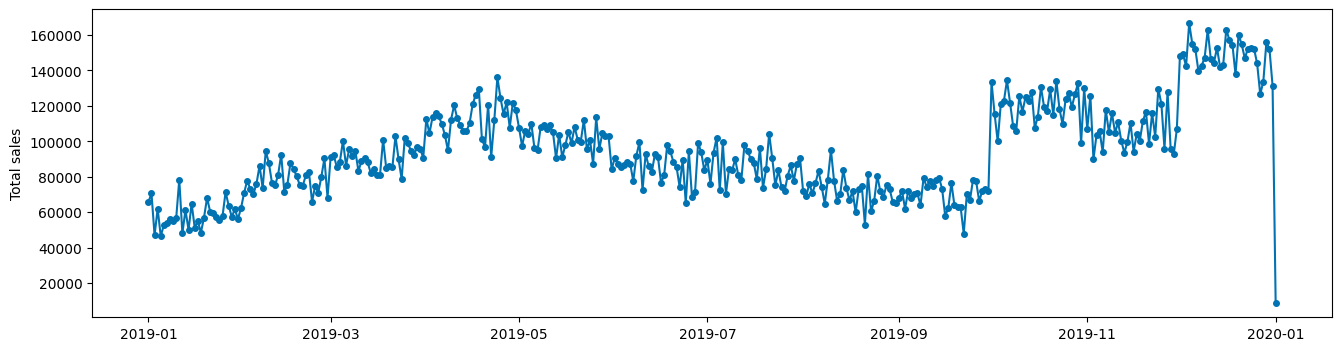

In [36]:
plot_series(df_daily_sales)

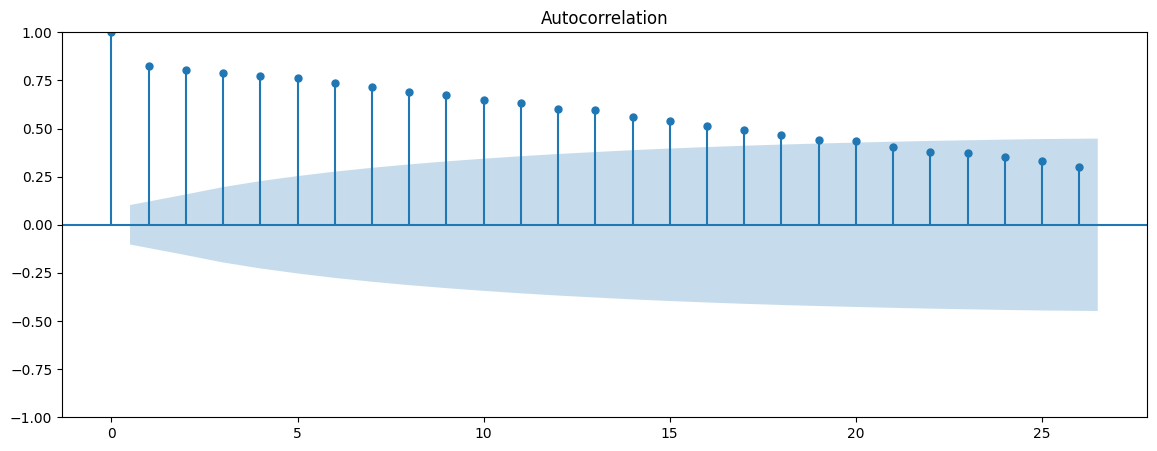

In [37]:
plot_acf(df_daily_sales).set_size_inches(14, 5)

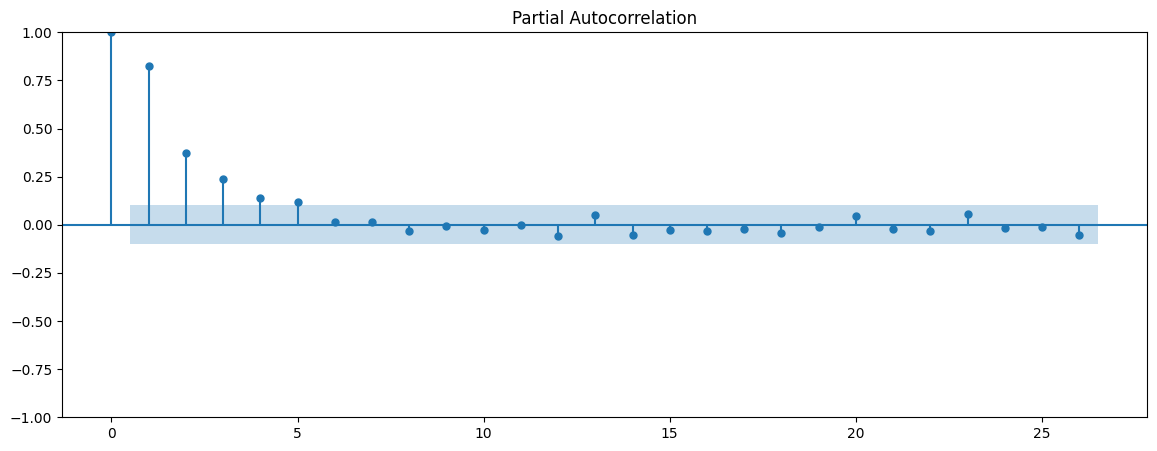

In [38]:
plot_pacf(df_daily_sales).set_size_inches(14, 5)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Total sales'>)

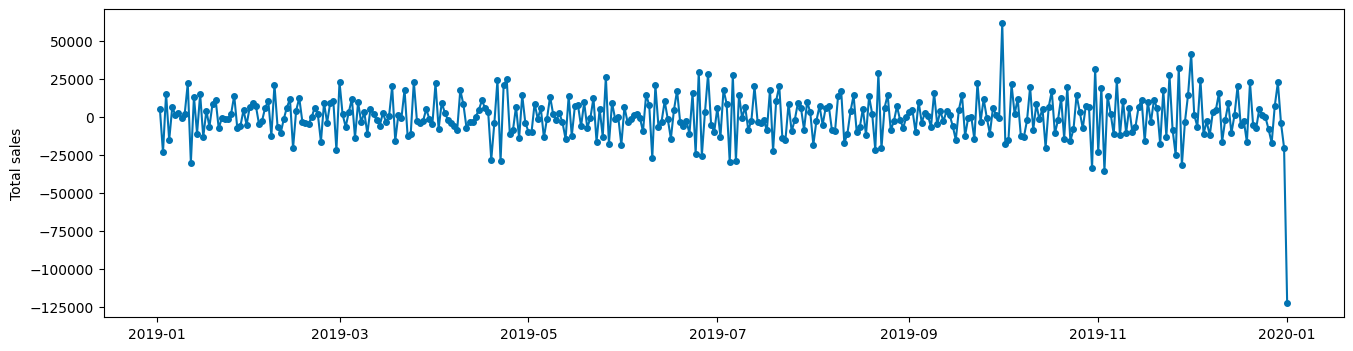

In [39]:
plot_series(df_daily_sales.diff())

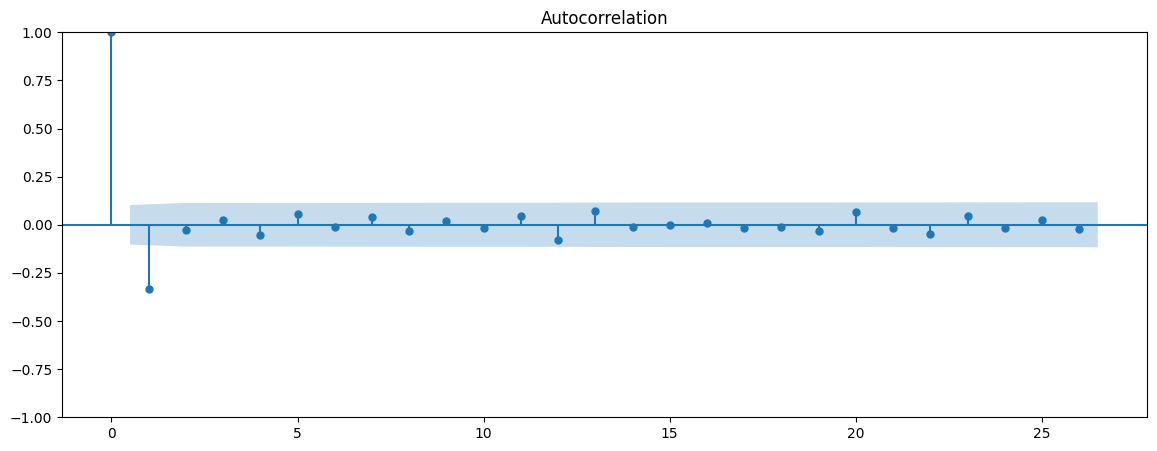

In [40]:
plot_acf(df_daily_sales.diff().dropna()).set_size_inches((14,5));

## Modeling

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [42]:
# Do train-test split
y_train, y_test = temporal_train_test_split(df_daily_sales, test_size=36)

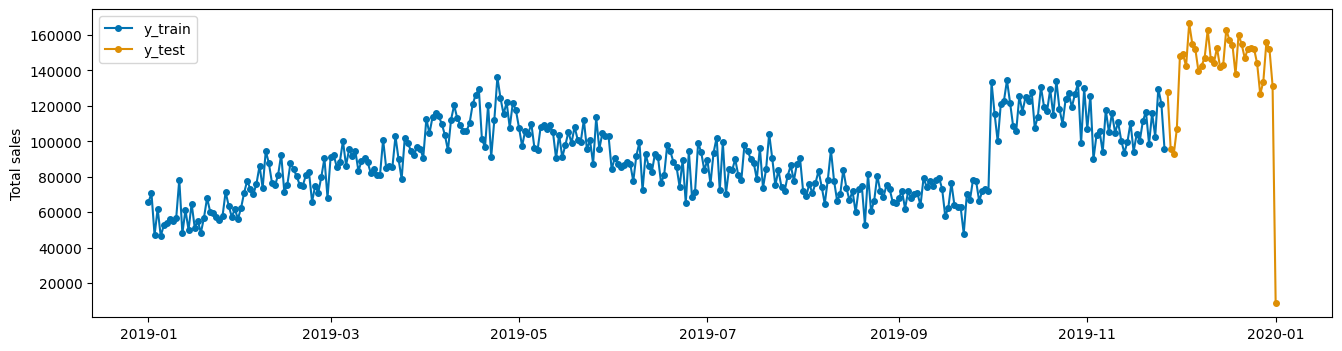

In [43]:
# check the time series after splitting
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [44]:
# Definisikan model SARIMA (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(y_train,
                       order=(2,1,2),        # (p,d,q) untuk komponen ARIMA
                       seasonal_order=(1,1,1,30),  # (P,D,Q,s) untuk komponen musiman (s=30 untuk pola bulanan)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


**Prediction**

In [61]:
fh = ForecastingHorizon(y_test.index, is_relative=False)  # Gunakan indeks y_test untuk prediksi
y_pred_sarima = sarima_fit.predict(start=fh[0], end=fh[-1])

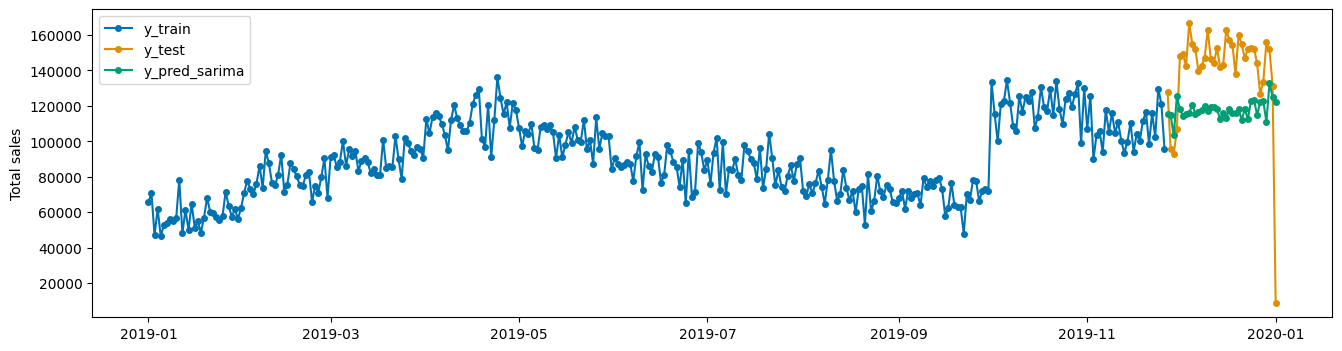

In [62]:
plot_series(y_train, y_test, y_pred_sarima, labels=["y_train", "y_test", "y_pred_sarima"]);

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_sarima)
mse = mean_squared_error(y_test, y_pred_sarima)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 31300.738010406276
MSE: 1305118593.2610781
RMSE: 36126.42513813231


In [55]:
mean_absolute_percentage_error(y_test, y_pred_sarima) * 100

55.46703132369027

# Prophet

**Modeling**

In [68]:
# define Prophet model
prophet_forecaster = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False,

)
# Tambahkan seasonality tambahan jika diperlukan
prophet_forecaster.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_forecaster.add_seasonality(name='quarterly', period=91.25, fourier_order=7)


In [69]:
# fit forecaster to data
prophet_forecaster.fit(y_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8_a90z_/wc61_lrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8_a90z_/yfmp3ame.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8014', 'data', 'file=/tmp/tmpr8_a90z_/wc61_lrb.json', 'init=/tmp/tmpr8_a90z_/yfmp3ame.json', 'output', 'file=/tmp/tmpr8_a90z_/prophet_modelnmt1sbbg/prophet_model-20250308153132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:31:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet(daily_seasonality=False, seasonality_mode='multiplicative',
        weekly_seasonality=False, yearly_seasonality=True)

In [70]:
# do prediction based on forecast horizon we already defined
y_pred_prophet = prophet_forecaster.predict(fh=fh)

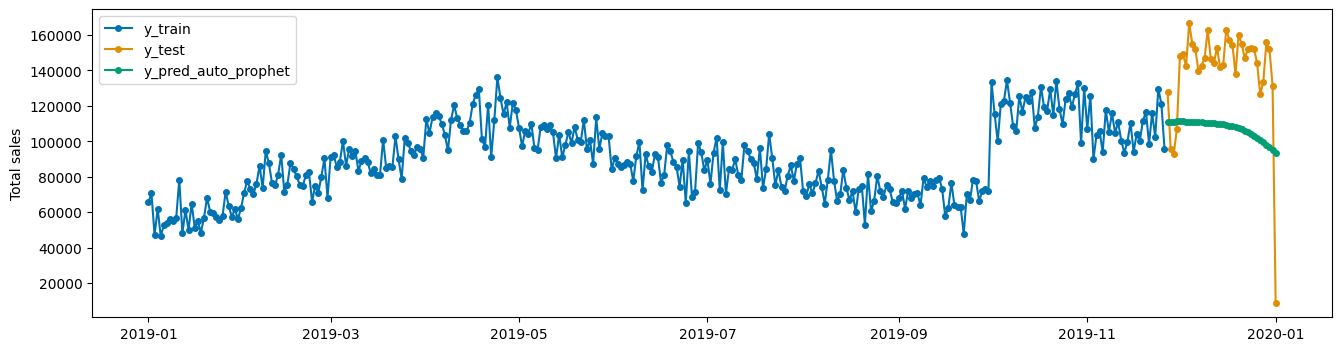

In [71]:
# plot the forecast result
plot_series(y_train, y_test, y_pred_prophet, labels=["y_train", "y_test", "y_pred_auto_prophet"]);

In [78]:
mean_absolute_percentage_error(y_test, y_pred_prophet) * 100

52.60532026286171

MAPE yang didapat dari 2 model prediksi hasilnya tidak memuaskan, teteapi jika memilih antara 2 model , model prophet lebih baik kareana nilai MAPE lebih kecil dibandingkan dengan mpdel ARIMA.
